# setting

In [1]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Elo_kaggle/py/models/')
sys.path.append(home_path + '/Desktop/Elo_kaggle/py/')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg')

# module

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import feather # fast reading data
from datetime import datetime
from sklearn.metrics import mean_squared_error, auc, roc_curve
import requests, time, base
import Regressor, Ensemble
import GradientBoosting as gb
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
%matplotlib inline

In [3]:
import importlib
importlib.reload(base)
importlib.reload(Regressor)
importlib.reload(Ensemble)
importlib.reload(gb)

<module 'GradientBoosting' from '/Users/takutokotsubo/Desktop/Elo_kaggle/py/models/GradientBoosting.py'>

In [4]:
# for instance
Process = base.Process()
Applicate = base.Applicate()

# Read data

サンプルデータもしくは使用データの読み込み, 使用する特徴量の選択

In [5]:
# read file sample
train, test, features, best_features, target = \
Process.read_data(train_name = "train_sample",
                  test_name = "test_sample",
                  features_name = "features_sample",
                  best_features_name = "best_features_500",
                  num = 500)

201917 observations and 10 features in train set.
123623 observations and 8 features in test set.
6 observations and 1 features in features set.
not exist best features list


In [5]:
# read file
train, test, features, best_features, target = \
Process.read_data(train_name = "train_20190112",
                  test_name = "test_20190112",
                  features_name = "features_20190112",
                  best_features_name = "basic_features_importance",
                  num = 500)

201917 observations and 1687 features in train set.
123623 observations and 1685 features in test set.
1683 observations and 1 features in features set.
1683 observations and 2 features in features importance set.


In [10]:
# check 
len(best_features)

500

# Regession model

In [52]:
# Ridge regression
# clf = Ridge(alpha=100)
# val_pred_ridge, test_pred_ridge = Regressor.Regressors(clf,train,test,features,target) 
# Lasso regression
clf = Lasso(alpha=100)
with base.timer("Lasso Regression"):
    val_pred_lasso, test_pred_lasso = Regressor.Regressors(clf,train,test,features,target)
# Ensemble regression (bagging)
# clf = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, max_samples=0.3)
# val_pred_bag, test_pred_bag = Regressor.Regressors(clf,train,test,features,target) 

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


In [53]:
# print validation RMSE 
print("Ridge regression validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, val_pred_ridge)))
print("Lasso regression validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, val_pred_lasso)))
print("Bagging regression validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, val_pred_bag)))  

Ridge regression validation RMSE: 4.4739
Lasso regression validation RMSE: 3.8264
Bagging regression validation RMSE: 3.8392


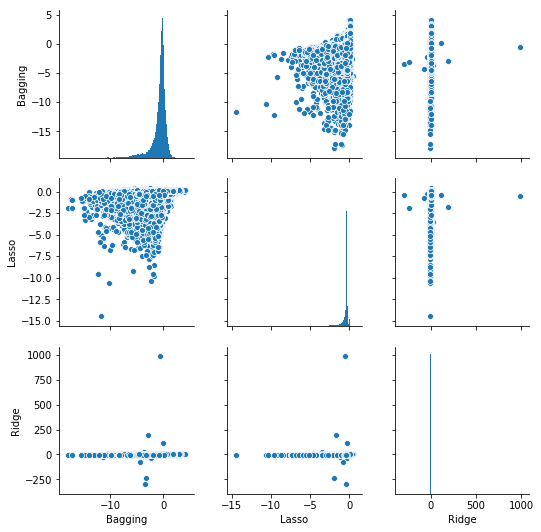

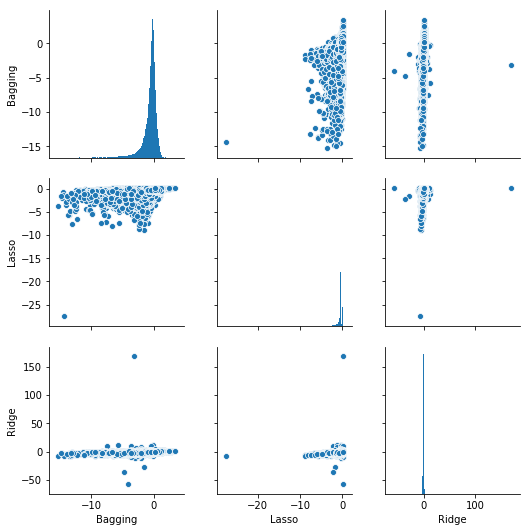

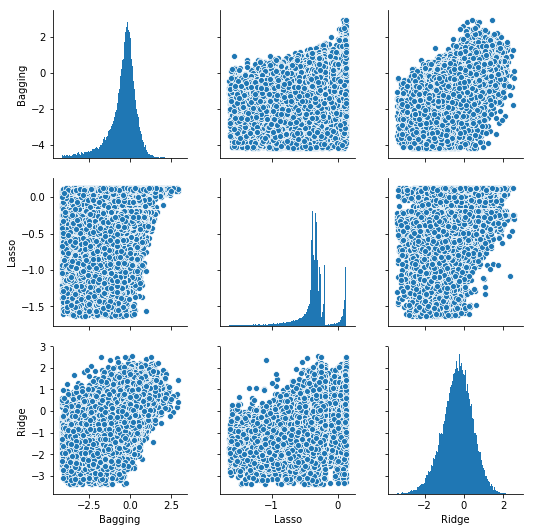

In [54]:
# set data frame
df_val = pd.DataFrame({'Ridge':val_pred_ridge, 'Lasso':val_pred_lasso, "Bagging" : val_pred_bag})
df_test = pd.DataFrame({'Ridge':test_pred_ridge, 'Lasso':test_pred_lasso, "Bagging" : test_pred_bag})
# plot validation data set 
sns.pairplot(df_val,diag_kws={'bins': 500}) # all values
sns.pairplot(df_val[df_val.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)],
             diag_kws={'bins': 500}) # non outliers
# plot test data set 
sns.pairplot(df_test,diag_kws={'bins': 500}) # all values
sns.pairplot(df_test[df_test.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)],
             diag_kws={'bins': 500}) # non outliers

In [55]:
# submit file
Process.submit(test_pred_ridge,tech="Ridge")
Process.submit(test_pred_lasso,tech="Lasso")
Process.submit(test_pred_bag,tech="Bagging")

In [56]:
Process.line("finished Regression calculation")

# Gradient Boosting method

## Light GBM

1: 各パラメータを調整

2: 外れを予測する分類モデルを作成

3: 外れ値ありモデルと外れ値なしモデルを作成

4: 分類の予測を元に, 加重平均

(5: 可視化コード) 

(6: 特徴量抽出コード)

### Model Parameters

In [6]:
# parameters
param_lgb1 = Process.open_parameter(file_name = 'kernel_param_tuning_lgb')
param_lgb2 = Process.open_parameter(file_name = 'kernel_param_lgb')
param_lgb3 = Process.open_parameter(file_name = 'kernel_param_auc')
# validation method
Sfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=831)
Kfolds = KFold(n_splits=5, shuffle=True, random_state=831)

### Classification model

In [7]:
# model
with base.timer("Light GBM Classification"):
    class_val_pred, class_test_pred, class_importance = \
    gb.GradientBoosting(algorithm = gb.Lightgbm,
                        param_set = param_lgb3,
                        train = train,
                        test = test,
                        features = features,
                        target = train['target_class'],
                        folds = Sfolds)

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.998463	valid_1's auc: 0.882015
[200]	training's auc: 0.999909	valid_1's auc: 0.881489
Early stopping, best iteration is:
[27]	training's auc: 0.960375	valid_1's auc: 0.883406
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.994517	valid_1's auc: 0.87197
[200]	training's auc: 0.998554	valid_1's auc: 0.865454
Early stopping, best iteration is:
[38]	training's auc: 0.979122	valid_1's auc: 0.878233
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.998524	valid_1's auc: 0.870016
[200]	training's auc: 0.999931	valid_1's auc: 0.868584
Early stopping, best iteration is:
[87]	training's auc: 0.997678	valid_1's auc: 0.871973
fold n°4
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.998685	valid_1's auc: 0.879696
[200]	training's auc: 0.99992	valid_1's auc: 0.878241
Early s

In [11]:
# result (auc)
fpr, tpr, thresholds = roc_curve(train['target_class'].values, class_val_pred)
print("Lightgbm Classification validation AUC : %.4f" % auc(fpr, tpr))

Lightgbm Classification validation AUC : 0.8746


### Regression model ( non outlier model )

In [48]:
# non outlier model
with base.timer("Light GBM non outlier model"):
    non_outlier_val_pred, non_outlier_test_pred, non_outlier_importance = \
    gb.GradientBoosting(algorithm = gb.Lightgbm,
                        param_set = param_lgb1,
                        train = train.query('target_class == 0'), # non outlier
                        test = test,
                        features = features,
                        target = target,
                        folds = Kfolds)

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.8325	valid_1's rmse: 3.91583
[200]	training's rmse: 3.83194	valid_1's rmse: 3.91598
Early stopping, best iteration is:
[20]	training's rmse: 3.83313	valid_1's rmse: 3.91577
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.83068	valid_1's rmse: 3.92262
[200]	training's rmse: 3.83006	valid_1's rmse: 3.92292
Early stopping, best iteration is:
[3]	training's rmse: 3.8316	valid_1's rmse: 3.9224
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.84727	valid_1's rmse: 3.85741
[200]	training's rmse: 3.84669	valid_1's rmse: 3.85755
Early stopping, best iteration is:
[60]	training's rmse: 3.8475	valid_1's rmse: 3.85738
fold n°4
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.88559	valid_1's rmse: 3.70002
[200]	training's rmse: 3.88491	valid_1's rmse: 3.70035
Early stop

In [53]:
# normal model
with base.timer("Light GBM normal model"):
    lgb_val_pred, lgb_test_pred, lgb_importance = \
    gb.GradientBoosting(algorithm = gb.Lightgbm,
                        param_set = param_lgb1,
                        train = train, # non outlier
                        test = test,
                        features = features,
                        target = target,
                        folds = Sfolds)

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.8441	valid_1's rmse: 3.84787
[200]	training's rmse: 3.84095	valid_1's rmse: 3.84547
[300]	training's rmse: 3.83878	valid_1's rmse: 3.84414
[400]	training's rmse: 3.83777	valid_1's rmse: 3.84366
[500]	training's rmse: 3.83711	valid_1's rmse: 3.84353
[600]	training's rmse: 3.83672	valid_1's rmse: 3.84359
[700]	training's rmse: 3.83643	valid_1's rmse: 3.84365
Early stopping, best iteration is:
[511]	training's rmse: 3.83706	valid_1's rmse: 3.84353
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.84261	valid_1's rmse: 3.85321
[200]	training's rmse: 3.83937	valid_1's rmse: 3.85112
[300]	training's rmse: 3.83719	valid_1's rmse: 3.84992
[400]	training's rmse: 3.8361	valid_1's rmse: 3.84951
[500]	training's rmse: 3.83543	valid_1's rmse: 3.84943
[600]	training's rmse: 3.83502	valid_1's rmse: 3.84946
[700]	training's rmse: 3.83473	valid_1's rmse: 3.8495

In [54]:
# result
print("Lightgbm non outlier validation RMSE: %.4f" % np.sqrt(mean_squared_error(train.query('target_class == 0').values, non_outlier_val_pred)))
print("Lightgbm normal validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, lgb_val_pred)))
# submit
# Process.submit(test_pred_lgb,tech = "Lightgbm_sample")

Lightgbm validation RMSE: 3.8424


### Ensemble

train['final'] = train['binpredict'] (-33.21928) +(1-train['binpredict']) train['no_outlier']

In [58]:
# execute
ensemble_pred = class_test_pred*(-33.21928) + (1 - class_test_pred)*non_outlier_test_pred
# Process.submit(ensemble_pred,tech = "Lightgbm_classification_regression")

###  Visualization

/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


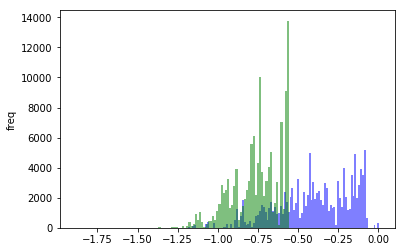

In [73]:
# target histogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.hist(target, bins=100,color='red', alpha=0.5, normed=True)
ax.hist(lgb_test_pred, bins=100, color='blue', alpha=0.5)
ax.hist(ensemble_pred, bins=100, color='green', alpha=0.5)
ax.set_ylabel('freq')
# ax.legend(loc='upper left')
fig.show()

In [55]:
# importance 
Process.display_importances(class_importance,title="LightGBM Classification importance",file_name = None)

NameError: name 'class_importance' is not defined

### Extract best features

優れた特徴量を任意の数選択し、記録する

In [58]:
#extract best features
best_features = Process.extract_best_features(class_importance = lgb_importance_df,
                                              num=500,
                                              file_name="best_features_500")

## Xgboost

分類はできない??

In [29]:
# parameters
param_xgb1 = Process.open_parameter(file_name = 'kernel_param_xgb')
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=831)

In [ ]:
# model
with base.timer("Xgboost"):
    val_pred_xgb, test_pred_xgb, xgb_importance_df \
    = gb.GradientBoosting(algorithm = gb.Xgboost_Regressor,
                          param_set = param_xgb1,
                          train = train,
                          test = test,
                          features = features,
                          target = target,
                          folds = folds)

fold n°1
[0]	train-rmse:3.94772	valid-rmse:3.95092
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[100]	train-rmse:3.56059	valid-rmse:3.79812
[200]	train-rmse:3.31366	valid-rmse:3.73311
[300]	train-rmse:3.14668	valid-rmse:3.70365
[400]	train-rmse:3.02128	valid-rmse:3.69066
[500]	train-rmse:2.92815	valid-rmse:3.68465
[600]	train-rmse:2.85235	valid-rmse:3.6807


In [1]:
# result
print("Xgboost validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, val_pred_xgb)))
# submit
Process.submit(test_pred_lgb,tech = "xgboost_feature_1037_param1")

NameError: name 'np' is not defined

In [47]:
Process.display_importances(xgb_importance_df,title="Xgboost",file_name = None)

## Combine classification and regression (light gbm)

ノーマルモデルと外れ値を除いたモデルを, 外れ値か否かの二値分類の結果をもとに組み合わせる

### Make under sampling data and Set paramters and execute model

任意の分割数(num)により, kmeans法により似ているデータを分割し, 任意の比率(rate)を用いて外れ値データの個数に全体データを合わせる

In [6]:
with base.timer("Under sampling method"):
    under_data = Applicate.under_sampling(num = 5,
                                          rate = 0.1,
                                          train = train,
                                          features = best_features[:200])

outlier rate is 1.0930%, So we increase the proportion of outliers to 10.0000%
22069 observations and 1687 features in train set.


In [8]:
# regression parameters
param_reg = Process.open_parameter(file_name = 'kernel_param_tuning_lgb')
# log_loss parameters
param_loss = Process.open_parameter(file_name = 'kernel_param_logloss')
# validation for regression
Sfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=831)
# validation for classification
Kfolds = KFold(n_splits=5, shuffle=True, random_state=831)

### Basic normal model

In [73]:
with base.timer("Light GBM basic regression"):
    basic_val_lgb, basic_test_lgb, basic_importance_lgb = \
    gb.GradientBoosting(algorithm = gb.Lightgbm,
                        param_set = param_reg,
                        train = train,
                        test = test,
                        features = best_features,
                        target = target,
                        folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=831))

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71783	valid_1's rmse: 3.75382
[200]	training's rmse: 3.64302	valid_1's rmse: 3.71081
[300]	training's rmse: 3.59157	valid_1's rmse: 3.68958
[400]	training's rmse: 3.5546	valid_1's rmse: 3.67842
[500]	training's rmse: 3.52716	valid_1's rmse: 3.67225
[600]	training's rmse: 3.50509	valid_1's rmse: 3.6684
[700]	training's rmse: 3.48663	valid_1's rmse: 3.66607
[800]	training's rmse: 3.47175	valid_1's rmse: 3.66463
[900]	training's rmse: 3.45764	valid_1's rmse: 3.66379
[1000]	training's rmse: 3.44605	valid_1's rmse: 3.66308
[1100]	training's rmse: 3.43402	valid_1's rmse: 3.66242
[1200]	training's rmse: 3.4225	valid_1's rmse: 3.66185
[1300]	training's rmse: 3.41164	valid_1's rmse: 3.66153
[1400]	training's rmse: 3.40058	valid_1's rmse: 3.66113
[1500]	training's rmse: 3.38963	valid_1's rmse: 3.66063
[1600]	training's rmse: 3.37866	valid_1's rmse: 3.66057
[1700]	training's rmse: 3.36891	valid_1's rm

In [74]:
# save tmp folder
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/basic_val' + '.npy', basic_val_lgb)
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/basic_test' + '.npy', basic_test_lgb)
#extract best features
best_features = Process.extract_best_features(importance_df = basic_importance_lgb,
                                              num=500,
                                              file_name="basic_features_importance")
# visualize importance
Process.display_importances(importance_df = basic_importance_lgb,
                            title = "LightGBM basic model",
                            file_name = "basic_best_features_500")

### Down sampling model

In [12]:
with base.timer("Light GBM down sampling regression"):
    down_samp_val_lgb, down_samp_test_lgb, down_samp_importance_lgb = \
    gb.GradientBoosting(algorithm = gb.Lightgbm,
                        param_set = param_reg,
                        train = under_data,
                        test = test,
                        features = features,
                        target = target,
                        folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=831))

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.70661	valid_1's rmse: 3.63442
[200]	training's rmse: 3.67454	valid_1's rmse: 3.63559
Early stopping, best iteration is:
[75]	training's rmse: 3.71531	valid_1's rmse: 3.63403
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71195	valid_1's rmse: 3.6227
[200]	training's rmse: 3.67603	valid_1's rmse: 3.6248
Early stopping, best iteration is:
[56]	training's rmse: 3.7276	valid_1's rmse: 3.62204
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.59032	valid_1's rmse: 3.85891
[200]	training's rmse: 3.55424	valid_1's rmse: 3.8605
Early stopping, best iteration is:
[9]	training's rmse: 3.62471	valid_1's rmse: 3.85823


In [10]:
# save tmp folder
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/down_samp_val' + '.npy', down_samp_val_lgb)
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/down_samp_test' + '.npy', down_samp_test_lgb)
#extract best features
best_features = Process.extract_best_features(importance_df = down_samp_importance_lgb,
                                              num=500,
                                              file_name="down_samp_features_importance")
# visualize importance
Process.display_importances(importance_df = down_samp_importance_lgb,
                            title = "LightGBM down_samp model",
                            file_name = "down_samp_best_features_500")

### Exclusive outlier model

In [10]:
with base.timer("Light GBM outlier regression"):
    non_outlier_val_lgb, non_outlier_test_lgb, non_outlier_importance_lgb = \
    gb.GradientBoosting(algorithm = gb.Lightgbm,
                        param_set = param_reg,
                        train = train[train["target_class"] == 0],
                        test = test,
                        features = features,
                        target = target[train["target_class"] == 0],
                        folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=831))

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.62857	valid_1's rmse: 1.63186
[200]	training's rmse: 1.58418	valid_1's rmse: 1.59406
[300]	training's rmse: 1.5584	valid_1's rmse: 1.57565
[400]	training's rmse: 1.54077	valid_1's rmse: 1.56563
[500]	training's rmse: 1.52718	valid_1's rmse: 1.55971
[600]	training's rmse: 1.51593	valid_1's rmse: 1.55599
[700]	training's rmse: 1.50594	valid_1's rmse: 1.55343
[800]	training's rmse: 1.49735	valid_1's rmse: 1.55156
[900]	training's rmse: 1.48963	valid_1's rmse: 1.55021
[1000]	training's rmse: 1.48302	valid_1's rmse: 1.54928
[1100]	training's rmse: 1.47734	valid_1's rmse: 1.54853
[1200]	training's rmse: 1.47189	valid_1's rmse: 1.548
[1300]	training's rmse: 1.46698	valid_1's rmse: 1.54756
[1400]	training's rmse: 1.46256	valid_1's rmse: 1.54712
[1500]	training's rmse: 1.45839	valid_1's rmse: 1.54686
[1600]	training's rmse: 1.45414	valid_1's rmse: 1.5467
[1700]	training's rmse: 1.45018	valid_1's rms

[2400]	training's rmse: 1.42276	valid_1's rmse: 1.55838
[2500]	training's rmse: 1.41943	valid_1's rmse: 1.55845
Early stopping, best iteration is:
[2393]	training's rmse: 1.423	valid_1's rmse: 1.55837


In [71]:
# save tmp folder
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/non_outlier_val' + '.npy', non_outlier_val_lgb)
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/non_outlier_test' + '.npy', non_outlier_test_lgb)
# remove memory save
# import gc
# del non_outlier_val_lgb
# del non_outlier_test_lgb
# gc.collect()
#extract best features
best_features = Process.extract_best_features(importance_df = non_outlier_importance_lgb,
                                              num=500,
                                              file_name="non_outlier_features_importance")
# visualize importance
Process.display_importances(importance_df = non_outlier_importance_lgb,
                            title = "LightGBM non outlier model",
                            file_name = "non_outlier_best_features_500")

### Training Model For Outliers Classification

In [75]:
with base.timer("Light GBM outlier clssigication"):
    class_val_lgb, class_test_lgb, class_importance_lgb = \
    gb.GradientBoosting(algorithm = gb.Lightgbm,
                        param_set = param_loss,
                        train = under_data,
                        test = test,
                        features = features,
                        target = train["target_class"],
                        folds = KFold(n_splits=3, shuffle=True, random_state=831))

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.150826	valid_1's binary_logloss: 0.151294
[200]	training's binary_logloss: 0.150825	valid_1's binary_logloss: 0.151297
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.150831	valid_1's binary_logloss: 0.151272
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.150468	valid_1's binary_logloss: 0.152587
[200]	training's binary_logloss: 0.15047	valid_1's binary_logloss: 0.152588
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.150594	valid_1's binary_logloss: 0.152525
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.15055	valid_1's binary_logloss: 0.152556
[200]	training's binary_logloss: 0.150554	valid_1's binary_logloss: 0.152554
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.150541	valid_1's binary_logloss: 0

In [76]:
# save tmp folder
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/class_val' + '.npy', class_val_lgb)
np.save(home_path + '/Desktop/Elo_kaggle/output/tmp/class_test' + '.npy', class_test_lgb)
#extract best features
best_features = Process.extract_best_features(importance_df = class_importance_lgb,
                                              num=500,
                                              file_name="classification_features_importance")
# visualize importance
Process.display_importances(importance_df = class_importance_lgb,
                            title = "LightGBM classification model",
                            file_name = "classification_best_features_500")

### Combine validation data and submit test data

In [ ]:
# load tmp data
basic_val_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/basic_val' + '.npy')
basic_test_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/basic_test' + '.npy')
down_samp_val_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/down_samp_val' + '.npy')
down_samp_test_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/down_samp_test' + '.npy')
non_outlier_val_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/non_outlier_val' + '.npy')
non_outlier_test_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/non_outlier_test' + '.npy')
class_val_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/class_val' + '.npy')
class_test_lgb = np.load(home_path + '/Desktop/Elo_kaggle/output/tmp/class_test' + '.npy')

In [77]:
# basic validation result
print("Lightgbm basic validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, basic_val_lgb)))
# combine validation
combine_val = basic_val_lgb.copy()
combine_val[train["target_class"] == 0] = non_outlier_val_lgb
print("Lightgbm combine validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, combine_val)))

LIghtgbm basic validation RMSE: 3.6605
LIghtgbm combine validation RMSE: 3.5437


In [78]:
# extract outlier index ( big 10000 value index)
outlier_idx = rankdata(class_test_lgb, method='ordinal') > (len(class_test_lgb) - 10000)
# combine test data
combine_test = non_outlier_test_lgb.copy()
combine_test[outlier_idx] = basic_test_lgb[outlier_idx]

In [11]:
# submit 3 patterns
#Process.submit(basic_test_lgb,tech = "Lightgbm_basic_model")
Process.submit(down_samp_test_lgb,tech = "Lightgbm_down_samp_model")
#Process.submit(non_outlier_test_lgb,tech = "Lightgbm_nonoutlier_model")
#Process.submit(combine_test,tech = "Lightgbm_combine_model")

# Ensemble

Ensemble.pyは作業が進み次第記入する.

In [57]:
# data set 
train_stack = np.vstack([val_pred_lasso,val_pred_bag,val_pred_lgb, val_pred_xgb]).transpose()
test_stack = np.vstack([test_pred_lasso,test_pred_bag,test_pred_lgb, test_pred_xgb]).transpose()

In [58]:
# Ridge regression
clf = Ridge(alpha=100)
val_pred_ensemble, test_pred_ensemble = Ensemble.Ensembles(clf,train_stack,test_stack,train,target) 

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


In [60]:
# result
print("Ensemble validation RMSE: %.4f" % np.sqrt(mean_squared_error(target.values, val_pred_ensemble)))
# submit
Process.submit(test_pred_ensemble,tech="lasso-bagging-lgb-xgb-stack")

Ensemble validation RMSE: 3.6567
